### Importation des librairies

In [187]:
import mlflow
import mlflow.sklearn
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow.models.signature import infer_signature
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import joblib
import warnings
#Traitement des messages d'erreur :
warnings.filterwarnings('ignore')
import timeit
#Librairie pour gérer l'espace mémoire du PC
import gc
#Librairie pour créer un dataset de train et un de test
from sklearn.model_selection import train_test_split
#Librairie pour l'encodage des variables catégorielles
from sklearn.preprocessing import LabelEncoder
#Librairies pour réaliser un pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
# Importation du package pour le SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
import math
#Librairie pour XGBoostClassifier
from xgboost import XGBClassifier
#Librairie pour les métriques avec GridSearch
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### Fonction utilisées dans le notebook

In [188]:
#Pipeline pour transformer les variables numériques à l'aide d'un SimpleImputer, d'un RobustScaler et d'un ColumnTransformer
def Preprocessing (numeric):
    """Pipeline pour réaliser un SimpleImputer, un RobustScaler et un ColumnTransformer sur les variables numériques"""
    #On prend la médiane pour les valeurs manquantes, et on traite les outliers grâce au RobustScaler.
    #Le ColumnTransformer nous permet de réaliser toutes ces opérations en une seule fois
    numeric_transfs = [('imputer',SimpleImputer(missing_values= np.NAN, strategy= 'median')),('scaler', RobustScaler())]
    numeric_pipeline = Pipeline(numeric_transfs)
    all_transfs = [("numeric",numeric_pipeline,numeric)]
    full_preprocessor = ColumnTransformer(all_transfs, remainder='passthrough')
    return full_preprocessor

In [189]:
#Création d'une fonction pour utiliser chaque modèle d'entrainement et afficher les différents résultats de métriques

def training_model (name_of_model, parameters):
    """Fonction afin d'entrainer différents modèle en retournant les résultats de différents métriques"""
    grid = GridSearchCV(name_of_model,
                        
                        parameters,
                        #Cross validation
                        cv=5, #Permet d'entrainer le modèle en le découpant en folds, ici on entrainte 5 fois le modèle 
                        scoring=accuracy_score,
                        n_jobs=-1, #Permet d'obliger le modèle à travailler sur tous les CPU du PC
                        refit='accuracy_score', #Permet de réajuster un estimateur en utilisant les meilleurs paramètres trouvés sur l'ensemble de données
                        return_train_score=True, #Permet de renvoyer les scores de train
                        verbose=1) #Permet de définir la quantité d'infos renvoyer par GridSearch pendant son déroulement
                                             
    model = make_pipeline(StandardScaler(with_mean=False), grid)
    
    start_time = timeit.default_timer()
    model.fit(X_train_smote, y_train_smote)
    elapsed = timeit.default_timer() - start_time
    elapsed = np.round(elapsed, 3)

    print("Le temps d'entrainement du modèle est de {0:.3f} millisecondes".format(elapsed), "\n")

    #Affichage des meilleurs paramètres
    best_params = grid.best_params_
    
    #Affichage des meilleurs métriques :
    best_estimators = grid.best_estimator_
    
    print("Les meilleurs paramètres du modèle sont : ", grid.best_params_)
    print("Le meilleur score du modèle est : ", grid.best_score_)
    print("Le coefficient de détermination moyen sur la base de test est de : ",
          grid.best_estimator_.score(X_test_transformed, y_test))
    
    #Affichage des résultats
    class_report = classification_report(y_test, model.predict(X_test_transformed))
    print(class_report)
    confusion_mat(y_test, model.predict(X_test_transformed))
    AUC_graph(y_test, model.predict(X_test_transformed), model.predict_proba(X_test_transformed)[:,1])
    
    
    accuracy = accuracy_score(y_test, model.predict(X_test_transformed))
    print("Le score accuracy du modèle est de : ", accuracy)
    f1 = f1_score(y_test, model.predict(X_test_transformed))
    print("Le score f1 du modèle pour la classe 1 est de : ", f1)
    precision = precision_score(y_test, model.predict(X_test_transformed))
    print("Le score precision du modèle pour la classe 1 est de : ", precision)
    recall = recall_score(y_test, model.predict(X_test_transformed))
    print("Le score recall du modèle pour la classe 1 est de : ", recall)
    
    return best_params

In [190]:
#Fonction pour affiche la matrice de confusion
def confusion_mat(y_true, y_pred):
    """Fonction pour calculer et afficher une matrice de conusion"""
    conf_mat = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(10,10))
    group_names = ['Vrais Négatifs', 'Faux Positifs', 'Faux Négatifs', 'Vrais Positifs']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues')
    
#Fonction pour afficher la courbe AUC
def AUC_graph(y_true, y_pred, y_pred_proba):
    """Fonction pour calculer et afficher la courbe AUC """
    dummy_class_report = classification_report(y_true, y_pred)
    model_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
    fig = plt.figure(figsize=(10,10))
    false_positive, true_positive, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(false_positive, true_positive, label = "AUC = %0.2f" %model_roc_auc_score)
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.xlabel("Taux de Faux Positifs")
    plt.ylabel("Taux de Vrais Positifs")
    plt.title("Courbe de l'AUC")
    plt.legend(loc = 'upper left')
    plt.show()
    return model_roc_auc_score, dummy_class_report

### Lecture des datasets

In [191]:
path = 'Projet_7/'

data_work = pd.read_csv(path + "data_work.csv")
data_target = pd.read_csv(path + "data_target.csv")

In [192]:
display(data_work.head())
data_test = data_work.head()

,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
0,Prêts de trésorerie,M,26,3 à 4,célibataire,0,1,202500,2,1,406597,9251,874,0,20
1,Prêts de trésorerie,F,46,5 à 8,marié(e),0,2,270000,1,0,1293502,56553,1400,0,7
2,Prêts renouvelables,M,52,3 à 4,célibataire,0,1,67500,2,0,135000,5357,867,0,3
3,Prêts de trésorerie,F,52,3 à 4,marié(e),0,2,135000,2,1,312682,23651,1050,0,19
4,Prêts de trésorerie,M,55,3 à 4,célibataire,0,1,121500,2,0,513000,12278,1149,0,6


In [195]:
display(data_target.head(40))
data_test = data_target.head()

,TARGET
0,1
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


### Séparation des données

In [150]:
#On commence par diviser le dataset en un dataset de train et un dataset de test avec une proportion de 80% / 20%
X_train, X_test, y_train, y_test = train_test_split(data_work, data_target, test_size = 0.2)
del data_target

In [151]:
X_train.shape, X_test.shape

((246008, 15), (61503, 15))

### Pré-traitement des données

In [152]:
#On remet la variable concernant une période sous un format positif
X_test['Delai_anticipation_pret'] = X_test['Delai_anticipation_pret'].mul(-1)
#On remet la variable concernant une période sous un format positif
X_train['Delai_anticipation_pret'] = X_train['Delai_anticipation_pret'].mul(-1)

#Création d'une variable avec la liste des colonnes catégorielles du dataset features
data_categ = list(data_work.select_dtypes(exclude=["number"]).columns)
#Création d'une variable avec la liste des colonnes numériques du dataset features
data_num = list(data_work.select_dtypes(exclude=["bool_","object_"]).columns)
print("Voici la liste des colonnes catégorielles : \n", data_categ)
print("Voici la liste des colonnes numériques : \n", data_num)
del data_work
#Permet d'initialiser la librairie gc
gc.enable()
#Permet de supprimer les objets qui ne sont plus utilisés
gc.collect()

Voici la liste des colonnes catégorielles : 
 ['Type_de_pret', 'Genre', 'Niveau_d_etudes', 'Regime_matrimonial']
Voici la liste des colonnes numériques : 
 ['Age', 'Nb_enfants', 'Nb_membre_famille', 'Montant_des_revenus', 'Note_region_client', 'Nb_demande_client', 'Montants_du_pret', 'Montant_des_annuites', 'Nb_jours_credits', 'Montant_anticipation_pret', 'Delai_anticipation_pret']


16211

In [153]:
#On va maintenant encoder les variables catégorielles grâce ai LabelEncoder
encoder = LabelEncoder()

for col in data_categ:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.fit_transform(X_test[col])
display(X_train)

,Type_de_pret,Genre,Age,Niveau_d_etudes,Regime_matrimonial,Nb_enfants,Nb_membre_famille,Montant_des_revenus,Note_region_client,Nb_demande_client,Montants_du_pret,Montant_des_annuites,Nb_jours_credits,Montant_anticipation_pret,Delai_anticipation_pret
162893,0,1,58,0,2,0,2,121500,2,0,254700,8582,1173,0,-9
155739,0,0,65,1,0,0,1,157500,2,2,1710000,23003,719,-1463,-6
220165,0,0,29,0,1,0,1,112500,2,1,170640,11287,1050,0,-10
167836,1,0,41,0,1,0,1,112500,2,1,292500,9515,1050,-1731,-9
198933,0,1,29,1,1,0,1,193500,2,1,297130,13476,1050,0,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288294,1,1,45,0,2,0,2,126000,2,1,270000,17857,1541,0,-8
290234,0,1,68,0,2,2,4,90000,2,5,163008,7612,1341,555,-8
193524,0,0,47,0,2,0,2,135000,2,1,582804,13252,1050,-3152,-3
133020,0,0,35,0,2,0,2,225000,2,2,916299,38038,2139,8147,-4


In [198]:
X_train.loc[X_train.index[1]]

Type_de_pret                       0
Genre                              0
Age                               65
Niveau_d_etudes                    1
Regime_matrimonial                 0
Nb_enfants                         0
Nb_membre_famille                  1
Montant_des_revenus           157500
Note_region_client                 2
Nb_demande_client                  2
Montants_du_pret             1710000
Montant_des_annuites           23003
Nb_jours_credits                 719
Montant_anticipation_pret      -1463
Delai_anticipation_pret           -6
Name: 155739, dtype: int64

### Pipelines

In [154]:
preprocessor_fitted = Preprocessing(data_num).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

In [155]:
print("Taille de X_train après avoir utiliser la fonction contenant les Pipelines : ", X_train_transformed.shape)
print("Taille de X_test après avoir utiliser la fonction contenant les Pipelines : ", X_test_transformed.shape)
#On voit que nous n'avons pas de différence ce qui indique que toutes les variables ont bien été traitées.

Taille de X_train après avoir utiliser la fonction contenant les Pipelines :  (246008, 15)
Taille de X_test après avoir utiliser la fonction contenant les Pipelines :  (61503, 15)


### SMOTE

In [156]:
#Nombre d'observations avant le SMOTE
sum_target_1 = (np.sum(y_train==1)).values
sum_target_0 = (np.sum(y_train==0)).values

print("Nous avons ", sum_target_1, " observations pour la classe à 1.")
print("Nous avons ", sum_target_0, " observations pour la classe à 0.")

Nous avons  [19905]  observations pour la classe à 1.
Nous avons  [226103]  observations pour la classe à 0.


In [157]:
#Utilisation du SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_transformed, y_train)

In [158]:
#Nombre d'observations après le SMOTE
sum_target_res_1 = (np.sum(y_train_smote==1)).values
sum_target_res_0 = (np.sum(y_train_smote==0)).values

print("Nous avons ", sum_target_res_1, " observations pour la classe à 1.")
print("Nous avons ", sum_target_res_0, " observations pour la classe à 0.")

Nous avons  [226103]  observations pour la classe à 1.
Nous avons  [226103]  observations pour la classe à 0.


### Recherche des hyperparamètres

In [159]:
xgb = XGBClassifier()

In [160]:
#parameters = { 
#    'model__max_depth': [4, 5],
#    'model__learning_rate': [0.001, 0.01, 0.1, 0.20],
#    'model__n_estimators': [100, 500, 1000],
#    "model__subsample":[0.9],
#    "model__colsample_bytree":[0.5],
#    "model__random_state": [42], 
#}

In [ ]:
#training_results_xgb = training_model(xgb, parameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[00:30:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__random_state", "model__subsample" } are not used.

Le temps d'entrainement du modèle est de 240.651 millisecondes 

Les meilleurs paramètres du modèle sont :  {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.001, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__random_state': 42, 'model__subsample': 0.9}
Le meilleur score du modèle est :  nan
Le coefficient de détermination moyen sur la base de test est de :  0.0842560525502821
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56583
           1       0.16      0.01      0.01      4920

    accuracy                           0.92     61503

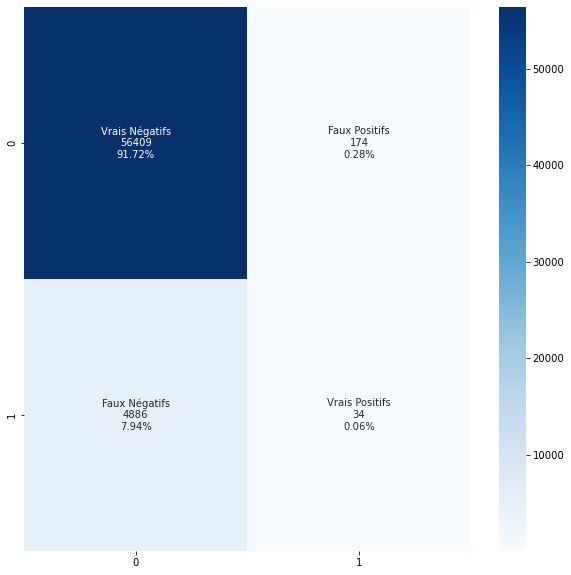

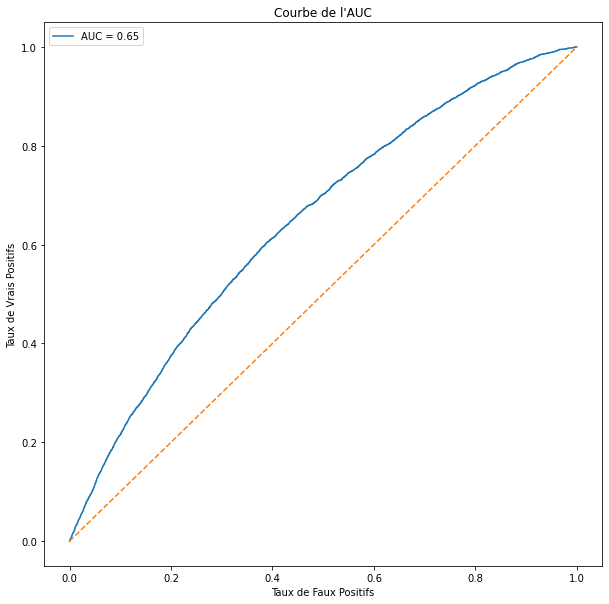

Le score accuracy du modèle est de :  0.9177275905240395
Le score f1 du modèle pour la classe 1 est de :  0.013260530421216851
Le score precision du modèle pour la classe 1 est de :  0.16346153846153846
Le score recall du modèle pour la classe 1 est de :  0.006910569105691057


In [162]:
#GridSearchCV avec les meilleurs hyperp aramètres
parameters = { 
    'model__max_depth': [4],
    'model__learning_rate': [0.001],
    'model__n_estimators': [100],
    "model__subsample":[0.9],
    "model__colsample_bytree":[0.5],
    "model__random_state": [42], 
}

training_results_xgb = training_model(xgb, parameters)

### Pipeline de prédiction

In [180]:
scaler = preprocessing.RobustScaler()
#Construction du Pipeline de prédiction comprenant le RobustScaler et le modèle XGBoostClassifier
pipeline = pipeline.Pipeline([('scaler', preprocessing.RobustScaler()),
                              ('xgb', XGBClassifier(**training_results_xgb))])

In [181]:
#Lancement de l'apprentissage du pipeline sur les données de train
pipeline.fit(X_train_smote, y_train_smote)

[00:40:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__random_state", "model__subsample" } are not used.



Pipeline(steps=[('scaler', RobustScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               model__colsample_bytree=0.5,
                               model__learning_rate=0.001, model__max_de

In [182]:
#Calcule du coefficient de détermination sur les données de test
pipeline.score(X_test_transformed, y_test)

0.9177275905240395

In [183]:
#Enfin on sérialise le pipeline à l'aide de la librairie joblib
joblib.dump(pipeline, 'pipeline_scoring.joblib')

['pipeline_scoring.joblib']

### Déploiement du modèle avec MLflow

In [184]:
#Utilisation de la fonction infer_signature afin d'extraire la signature à partir des données d'entrée et de sortie
with mlflow.start_run():
        signature = infer_signature(X_train_smote, y_train_smote)

In [185]:
#Sauvegarde du pipeline à l'aide de save_model tout en précisant la signature
mlflow.sklearn.save_model(pipeline, 'xgb_model_final', signature=signature)